In [1]:
import zipfile
import pandas as pd
import numpy as np
import string
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
dataset = zipfile.ZipFile('/content/Dataset.zip')
dataset.extractall()
dataset.close()

In [5]:
train_data = pd.read_csv('/content/Data_latih.csv')
test_data = pd.read_csv('/content/Data_uji.csv')

train_data.head(), test_data.head()

(    ID  label    tanggal                                              judul  \
 0   71      1  17-Aug-20  Pemakaian Masker Menyebabkan Penyakit Legionna...   
 1  461      1  17-Jul-20  Instruksi Gubernur Jateng tentang penilangan  ...   
 2  495      1  13-Jul-20  Foto Jim Rohn: Jokowi adalah presiden terbaik ...   
 3  550      1   8-Jul-20  ini bukan politik, tapi kenyataan Pak Jokowi b...   
 4  681      1  24-Jun-20       Foto Kadrun kalo lihat foto ini panas dingin   
 
                                               narasi nama file gambar  
 0  A caller to a radio talk show recently shared ...           71.jpg  
 1  Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...          461.png  
 2  Jokowi adalah presiden terbaik dlm sejarah ban...          495.png  
 3  Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...          550.png  
 4        Kadrun kalo lihat foto ini panas dingin . .          681.jpg  ,
        ID    tanggal                                              judul  \
 0 

PREPROS

In [6]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('indonesian'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

train_data['judul'] = train_data['judul'].apply(preprocess_text)
train_data['narasi'] = train_data['narasi'].apply(preprocess_text)
test_data['judul'] = test_data['judul'].apply(preprocess_text)
test_data['narasi'] = test_data['narasi'].apply(preprocess_text)

train_data['text'] = train_data['judul'] + " " + train_data['narasi']
test_data['text'] = test_data['judul'] + " " + test_data['narasi']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Word2vac

In [7]:
train_sentences = train_data['text'].apply(lambda x: x.split()).tolist()
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=2, workers=4)

def get_word2vec_embeddings(sentences, model):
    embeddings = []
    for sentence in sentences:
        words = sentence.split()
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if word_vectors:
            embeddings.append(np.mean(word_vectors, axis=0))
        else:
            embeddings.append(np.zeros(model.vector_size))
    return np.array(embeddings)

train_embeddings_word2vec = get_word2vec_embeddings(train_data['text'], word2vec_model)
test_embeddings_word2vec = get_word2vec_embeddings(test_data['text'], word2vec_model)


Glove

In [9]:
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_path = '/content/glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_path)

def get_glove_embeddings(sentences, embeddings_index, embed_size=100):
    embeddings = []
    for sentence in sentences:
        words = sentence.split()
        word_vectors = [embeddings_index[word] for word in words if word in embeddings_index]
        if word_vectors:
            embeddings.append(np.mean(word_vectors, axis=0))
        else:
            embeddings.append(np.zeros(embed_size))
    return np.array(embeddings)

train_embeddings_glove = get_glove_embeddings(train_data['text'], glove_embeddings)
test_embeddings_glove = get_glove_embeddings(test_data['text'], glove_embeddings)

Roberta

In [8]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')

def get_roberta_embeddings(texts, tokenizer, model):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze(0).numpy())
    return np.array(embeddings)

train_embeddings_roberta = get_roberta_embeddings(train_data['text'].tolist(), tokenizer, roberta_model)
test_embeddings_roberta = get_roberta_embeddings(test_data['text'].tolist(), tokenizer, roberta_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Smote

In [10]:
def apply_smote(embeddings, labels):
    smote = SMOTE(random_state=42)
    embeddings_resampled, labels_resampled = smote.fit_resample(embeddings, labels)
    return embeddings_resampled, labels_resampled

train_embeddings_word2vec_resampled, y_train_word2vec_resampled = apply_smote(
    train_embeddings_word2vec, train_data['label']
)
train_embeddings_glove_resampled, y_train_glove_resampled = apply_smote(
    train_embeddings_glove, train_data['label']
)
train_embeddings_roberta_resampled, y_train_roberta_resampled = apply_smote(
    train_embeddings_roberta, train_data['label']
)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validatio

Modeling

In [11]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return {
            'embedding': torch.tensor(self.embeddings[idx], dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset_word2vec = EmbeddingDataset(train_embeddings_word2vec_resampled, y_train_word2vec_resampled)
train_loader_word2vec = DataLoader(train_dataset_word2vec, batch_size=8, shuffle=True)

train_dataset_glove = EmbeddingDataset(train_embeddings_glove_resampled, y_train_glove_resampled)
train_loader_glove = DataLoader(train_dataset_glove, batch_size=8, shuffle=True)

train_dataset_roberta = EmbeddingDataset(train_embeddings_roberta_resampled, y_train_roberta_resampled)
train_loader_roberta = DataLoader(train_dataset_roberta, batch_size=8, shuffle=True)

class EmbeddingTestDataset(Dataset):
    def __init__(self, embeddings):
        self.embeddings = embeddings

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return {
            'embedding': torch.tensor(self.embeddings[idx], dtype=torch.float)
        }

test_dataset_word2vec = EmbeddingTestDataset(test_embeddings_word2vec)
test_loader_word2vec = DataLoader(test_dataset_word2vec, batch_size=8)

test_dataset_glove = EmbeddingTestDataset(test_embeddings_glove)
test_loader_glove = DataLoader(test_dataset_glove, batch_size=8)

test_dataset_roberta = EmbeddingTestDataset(test_embeddings_roberta)
test_loader_roberta = DataLoader(test_dataset_roberta, batch_size=8)

In [14]:
class RobertaClassifier(nn.Module):
    def __init__(self, input_dim, num_labels):
        super(RobertaClassifier, self).__init__()
        self.input_layer = nn.Linear(input_dim, 768)
        self.classifier = nn.Sequential(
            nn.Linear(768, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

    def forward(self, input_embeddings):
        embeddings = self.input_layer(input_embeddings)
        logits = self.classifier(embeddings)
        return logits

In [12]:
def train_model(model, train_loader, epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            embeddings = batch['embedding'].to(device)
            labels = batch['label'].to(device)

            logits = model(embeddings)
            loss = criterion(logits, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(train_loader):.4f}")


In [15]:
model_word2vec = RobertaClassifier(input_dim=100, num_labels=2)
train_model(model_word2vec, train_loader_word2vec)

model_glove = RobertaClassifier(input_dim=100, num_labels=2)
train_model(model_glove, train_loader_glove)

model_roberta = RobertaClassifier(input_dim=768, num_labels=2)
train_model(model_roberta, train_loader_roberta)


Epoch 1/100, Loss: 0.6941
Epoch 2/100, Loss: 0.6932
Epoch 3/100, Loss: 0.6927
Epoch 4/100, Loss: 0.6930
Epoch 5/100, Loss: 0.6927
Epoch 6/100, Loss: 0.6921
Epoch 7/100, Loss: 0.6921
Epoch 8/100, Loss: 0.6919
Epoch 9/100, Loss: 0.6919
Epoch 10/100, Loss: 0.6921
Epoch 11/100, Loss: 0.6920
Epoch 12/100, Loss: 0.6920
Epoch 13/100, Loss: 0.6914
Epoch 14/100, Loss: 0.6914
Epoch 15/100, Loss: 0.6915
Epoch 16/100, Loss: 0.6911
Epoch 17/100, Loss: 0.6909
Epoch 18/100, Loss: 0.6913
Epoch 19/100, Loss: 0.6913
Epoch 20/100, Loss: 0.6907
Epoch 21/100, Loss: 0.6904
Epoch 22/100, Loss: 0.6901
Epoch 23/100, Loss: 0.6907
Epoch 24/100, Loss: 0.6906
Epoch 25/100, Loss: 0.6901
Epoch 26/100, Loss: 0.6901
Epoch 27/100, Loss: 0.6894
Epoch 28/100, Loss: 0.6890
Epoch 29/100, Loss: 0.6894
Epoch 30/100, Loss: 0.6888
Epoch 31/100, Loss: 0.6885
Epoch 32/100, Loss: 0.6883
Epoch 33/100, Loss: 0.6881
Epoch 34/100, Loss: 0.6880
Epoch 35/100, Loss: 0.6875
Epoch 36/100, Loss: 0.6872
Epoch 37/100, Loss: 0.6869
Epoch 38/1

In [16]:
def predict_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            embeddings = batch['embedding'].to(device)
            logits = model(embeddings)
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
    return predictions

predictions_word2vec = predict_model(model_word2vec, test_loader_word2vec)
predictions_glove = predict_model(model_glove, test_loader_glove)
predictions_roberta = predict_model(model_roberta, test_loader_roberta)

test_data['predicted_word2vec'] = predictions_word2vec
test_data['predicted_glove'] = predictions_glove
test_data['predicted_roberta'] = predictions_roberta

test_data.to_csv('/content/predicted_test_data.csv', index=False)


In [17]:
file_path = '/content/predicted_test_data.csv'
predict = pd.read_csv(file_path)

print(predict.columns)


Index(['ID', 'tanggal', 'judul', 'narasi', 'nama file gambar', 'text', 'label',
       'predicted_word2vec', 'predicted_glove', 'predicted_roberta'],
      dtype='object')


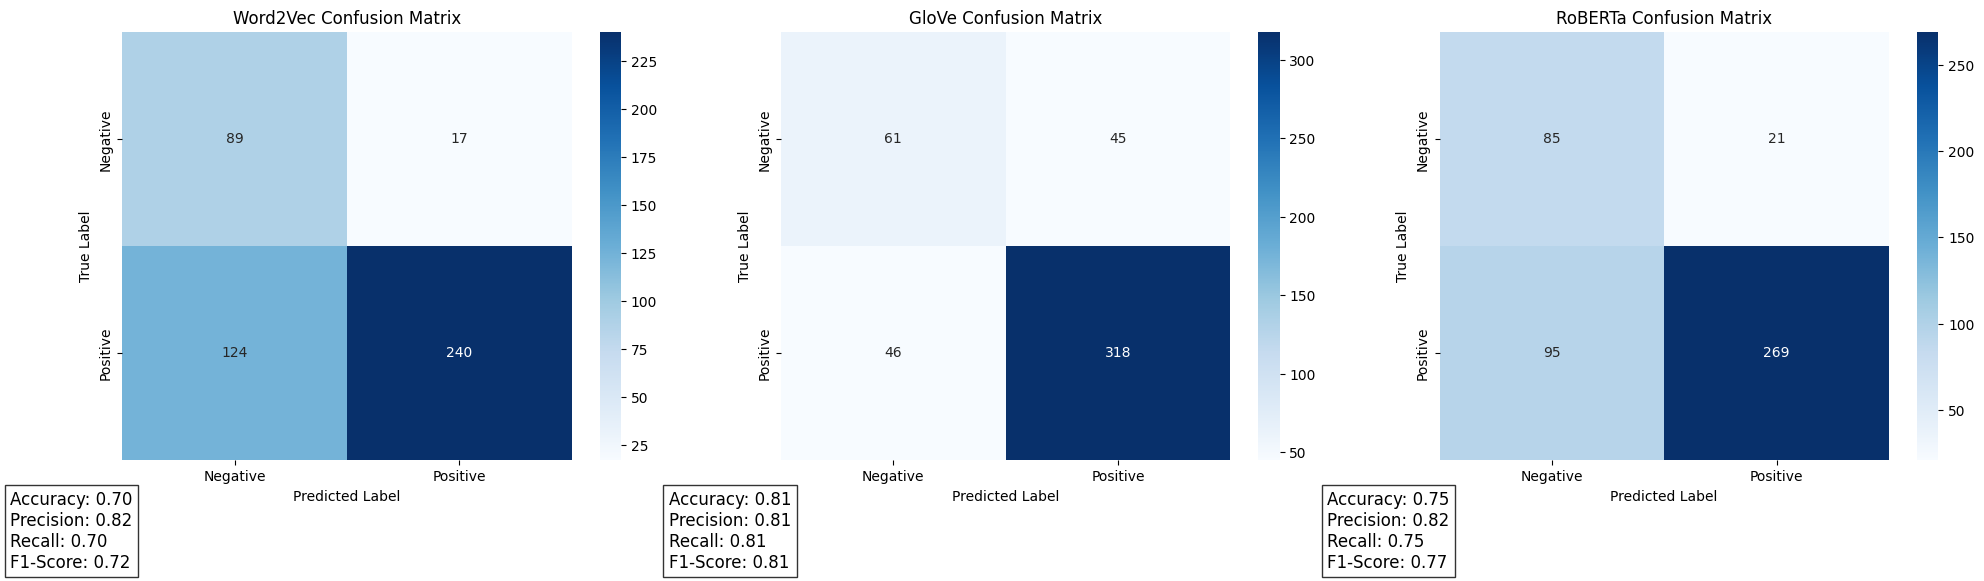

In [18]:
def evaluate_model(y_true, y_pred, method_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, conf_matrix

y_true = predict['label']
metrics_word2vec = evaluate_model(y_true, predict['predicted_word2vec'], "Word2Vec")
metrics_glove = evaluate_model(y_true, predict['predicted_glove'], "GloVe")
metrics_roberta = evaluate_model(y_true, predict['predicted_roberta'], "RoBERTa")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (method_name, metrics) in enumerate(zip(
    ["Word2Vec", "GloVe", "RoBERTa"],
    [metrics_word2vec, metrics_glove, metrics_roberta]
)):
    accuracy, precision, recall, f1, conf_matrix = metrics
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'], ax=axes[idx])
    axes[idx].set_title(f"{method_name} Confusion Matrix")
    axes[idx].set_xlabel("Predicted Label")
    axes[idx].set_ylabel("True Label")
    metrics_text = f"Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1-Score: {f1:.2f}"
    axes[idx].text(-0.5, 2.5, metrics_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()
